<a href="https://colab.research.google.com/github/sktoyo/GraphConvolutionalNetwork/blob/main/toy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# 개발환경 세팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Library import

In [ ]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

import pandas as pd
import scipy.sparse as sp
import numpy as np
import random

import datetime

## Input data

In [ ]:
# Toy graph
karate_G = nx.karate_club_graph()

karate_G = nx.karate_club_graph()
karate_adj = nx.adj_matrix(karate_G)

## Tensorboard codes

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Util functions

In [ ]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape


def convert_sparse_matrix_to_sparse_tensor(inputs):
    coo = inputs.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    output = tf.SparseTensor(indices, coo.data.astype('float64'), coo.shape)
    output = tf.dtypes.cast(output, tf.float32)
    return output


def dropout_dense(x, drop_rate):
    return tf.nn.dropout(x, rate=drop_rate)


def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt)#.tocoo()
    return convert_sparse_matrix_to_sparse_tensor(adj_normalized)


def get_norm_terms(adj):
    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    return pos_weight, norm

def mask_generation(labels_df, sample_df):
  mask = [0]*len(labels_df)
  idx_list = sample_df.index.values.tolist()
  for idx in idx_list:
    mask[idx] = 1
  return mask

def data_split(adj, validation_rate,
               test_rate):  # get train set, validation set, test set, using upper triangle of adj matrix, in AutoEncoder
    coords, values, shape = sparse_to_tuple(adj)
    test_num = int(len(values) * test_rate)
    validation_num = int(len(values) * validation_rate)

    # create positive set for train, validation, test from
    coords = coords.tolist()
    positive_set = np.array([coo for coo in coords if coo[0] < coo[1]])
    positive_idx = np.array([coo[0] * shape[0] + coo[1] for coo in positive_set])

    np.random.shuffle(positive_set)

    test_pos = positive_set[:test_num]
    valid_pos = positive_set[test_num:(test_num + validation_num)]
    train_edges = positive_set[(test_num + validation_num):]

    # create negative set for validation, test
    negative_idx_list = list()


    while len(negative_idx_list) < test_num + validation_num:
        i = random.randrange(shape[0])
        j = random.randrange(shape[0])
        if i < j:
            idx = i * shape[0] + j
            if idx not in positive_idx:
                negative_idx_list.append(idx)

    negative_idx = np.array(negative_idx_list)

    np.random.shuffle(negative_idx)
    test_neg = np.array([[idx // shape[0], idx % shape[0]] for idx in negative_idx[:test_num]])
    valid_neg = np.array(
        [[idx // shape[0], idx % shape[0]] for idx in negative_idx[test_num:(test_num + validation_num)]])

    data = np.ones(len(train_edges))

    # reconstruct train adjacency matrix
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    return adj_train, train_edges, valid_pos, valid_neg, test_pos, test_neg

def get_roc_score(edges_pos, edges_neg, model, adj_orig):
  def sigmoid(x):
    return 1 /(1 + np.exp(-x))

  reconstucted = gae.reconstructed
  preds = []
  pos = []
  for e in edges_pos:
    preds.append(sigmoid(reconstucted[e[0],e[1]]))
    pos.append(adj_orig[e[0],e[1]])

  preds_neg = []
  neg = []
  for e in edges_neg:
    preds_neg.append(sigmoid(reconstucted[e[0],e[1]]))
    neg.append(adj_orig[e[0],e[1]])
  
  preds_all = np.hstack([preds, preds_neg])
  labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
  roc_score = roc_auc_score(labels_all, preds_all)
  ap_score = average_precision_score(labels_all, preds_all)

  return roc_score, ap_score

# Model

## Layers

In [ ]:
class GraphConvolutionSparse(layers.Layer):
    def __init__(self, input_dim, output_dim, dropout, act=tf.nn.leaky_relu):
        super(GraphConvolutionSparse, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.act = act

    def build(self, inputs):
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim), initializer='GlorotNormal', trainable=True)

    def call(self, adj, inputs):
        x = inputs
        x = dropout_dense(x, self.dropout)
        x = tf.matmul(x, self.w)
        x = tf.sparse.sparse_dense_matmul(adj, x)
        outputs = self.act(x)
        return outputs

In [ ]:
class GraphConvolution(layers.Layer):
    def __init__(self, input_dim, output_dim, dropout, act=tf.nn.leaky_relu):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.act = act

    def build(self, inputs):
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim), initializer='GlorotNormal', trainable=True)

    def call(self, adj, inputs):
        x = inputs
        x = tf.nn.dropout(inputs, self.dropout)
        x = tf.matmul(x, self.w)
        x = tf.sparse.sparse_dense_matmul(adj, x)
        outputs = self.act(x)
        return outputs

In [ ]:
class InnerProductDecoder(layers.Layer):
    def __init__(self, dropout):
        super(InnerProductDecoder, self).__init__()
        self.dropout = dropout

    def call(self, inputs):
        x = tf.nn.dropout(inputs, self.dropout)
        x = tf.transpose(inputs)
        outputs = tf.matmul(inputs, x)
        return outputs

## Model

### AutoEncoder

In [ ]:
class GraphAutoEncoder(tf.keras.Model):
  
    def __init__(self, adj_orig, dropout, original_dim, intermediate_dim, latent_dim, name="GCNModel"):
        super(GraphAutoEncoder, self).__init__(name=name)
        self.dropout = dropout
        self.pos_weight, self.norm = get_norm_terms(adj_orig)
        self.adj_orig_tensor = tf.sparse.to_dense(convert_sparse_matrix_to_sparse_tensor(adj_orig))

        # layers
        self.graphconvolutionsparse = GraphConvolutionSparse(
            input_dim=original_dim,
            output_dim=intermediate_dim,
            dropout=self.dropout)
        self.graphconvolution = GraphConvolution(
            input_dim=intermediate_dim,
            output_dim=latent_dim,
            dropout=self.dropout)
        self.innerproductdecoder = InnerProductDecoder(
            dropout=self.dropout
        )

    def set_adj(self, adj):
        self.adj = adj

    def call(self, inputs):
        self.intermediate_latent = self.graphconvolutionsparse(self.adj, inputs)
        self.final_latent = self.graphconvolution(self.adj, self.intermediate_latent)
        self.reconstructed = self.innerproductdecoder(self.final_latent)

        # loss function
        loss = self.norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=tf.reshape(self.reconstructed, [-1]),
                                                                          labels=tf.reshape(self.adj_orig_tensor, [-1]),
                                                                          pos_weight=self.pos_weight))

        self.add_loss(loss)

        # acc function
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(self.reconstructed), 0.5), tf.int32),
                                      tf.cast(self.adj_orig_tensor, tf.int32))
        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.add_metric(acc, name='acc', aggregation='mean')

        return self.reconstructed

#### Validation callback

In [ ]:
class validationCallback(tf.keras.callbacks.Callback): # Auto-Encoder version

  def __init__(self, input_dataset, val_pos, val_neg, adj_orig):
    super(validationCallback, self).__init__()

    self.val_pos = val_pos
    self.val_neg = val_neg
    self.adj_orig = adj_orig
    self.roc_scores = []
    self.ap_scores = []
  
  def on_epoch_end(self, epoch, logs=None):
    reconstructed = self.model.predict(input_dataset)
    preds = []
    pos = []
    for e in self.val_pos:
      preds.append(tf.keras.activations.sigmoid(reconstructed[e[0],e[1]]))
      pos.append(self.adj_orig[e[0],e[1]])

    preds_neg = []
    neg = []
    for e in self.val_neg:
      preds_neg.append(tf.keras.activations.sigmoid(reconstructed[e[0],e[1]]))
      neg.append(adj_orig[e[0],e[1]])
    
    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    self.roc_scores.append(roc_score)
    ap_score = average_precision_score(labels_all, preds_all)
    self.ap_scores.append(ap_score)
    print('\nEpoch %05d: validation roc %f, validation ap %f' % (epoch+1, roc_score, ap_score))

#### Toy model

In [ ]:
# Original Adjacency matrix
adj_orig = karate_adj
adj_orig_tensor = tf.sparse.to_dense(convert_sparse_matrix_to_sparse_tensor(adj_orig))
adj_orig_dataset = tf.data.Dataset.from_tensors(adj_orig_tensor)

# Input feature matrix
feature_tensor = tf.eye(karate_adj.shape[0])
input_dataset = tf.data.Dataset.from_tensors(feature_tensor)


# Data split
adj_train, train_edges, valid_pos, valid_neg, test_pos, test_neg = data_split(adj_orig, 0.2, 0.1)

# Preporcess the adjacency matrix
adj_train = preprocess_graph(adj_train)

# Learning parameters
epochs = 100
input_layer_dim = int(adj_orig.shape[0])
first_layer_dim = 128
final_layer_dim = 64
dropout = 0

In [ ]:
# Define model
gae = GraphAutoEncoder(adj_orig, 0, input_layer_dim, first_layer_dim, final_layer_dim)
gae.set_adj(adj_train)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile model
gae.compile(optimizer)

# Define callbacks
validation_Callback = validationCallback(input_dataset, valid_pos, valid_neg, adj_orig)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Learning
history= gae.fit(x=input_dataset, epochs=epochs, callbacks=[callback, validation_Callback])

### Classifier

In [ ]:
class GraphClassifier(tf.keras.Model):
  
    def __init__(self, dropout, original_dim, intermediate_dim, latent_dim, labels, train_mask, name="GraphClassifier"):
        super(GraphClassifier, self).__init__(name=name)
        self.dropout = dropout
        self.train_mask = train_mask
        self.labels = labels

        # layers
        self.graphconvolutionsparse = GraphConvolutionSparse(
            input_dim=original_dim,
            output_dim=intermediate_dim,
            dropout=self.dropout)
        self.graphconvolution = GraphConvolution(
            input_dim=intermediate_dim,
            output_dim=latent_dim,
            dropout=self.dropout,
            act=lambda x: x)

    def set_adj(self, adj):
        self.adj = adj

    def call(self, inputs):
        self.intermediate_latent = self.graphconvolutionsparse(self.adj, inputs)
        self.final_latent = self.graphconvolution(self.adj, self.intermediate_latent)

        loss = tf.nn.softmax_cross_entropy_with_logits(logits=self.final_latent, labels=self.labels)
        mask = tf.cast(self.train_mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        loss *= mask
        loss = tf.reduce_mean(loss)

        # loss = masked_softmax_cross_entropy(self.final_latent, self.labels, self.train_mask)
        self.add_loss(loss)

        acc = masked_accuracy(self.final_latent, self.labels, self.train_mask)
        self.add_metric(acc, name='acc', aggregation='mean')

        return self.final_latent

#### Validation callback

In [ ]:
class validationCallback(tf.keras.callbacks.Callback): # Classifier version
  def __init__(self, labels, input_dataset, val_mask):
    super(validationCallback, self).__init__()

    self.labels = labels
    self.val_mask = val_mask
    self.acc_scores = []

  def on_epoch_end(self, epoch, logs=None):
    pred = self.model.predict(input_dataset)
    preds = []
    pos = []
    acc = masked_accuracy(pred, self.labels, self.val_mask)

    self.acc_scores.append(acc)
    print('\nEpoch %05d: validation acc %f' % (epoch+1, acc))

#### Classifier

In [ ]:
# Original Adjacency matrix
adj_orig = karate_adj
adj_orig_tensor = tf.sparse.to_dense(convert_sparse_matrix_to_sparse_tensor(adj_orig))
adj_orig_dataset = tf.data.Dataset.from_tensors(adj_orig_tensor)

# Input feature matrix
feature_tensor = tf.eye(karate_adj.shape[0], name='feature_tensor')
input_dataset = tf.data.Dataset.from_tensors(feature_tensor)

# output label matrix
label_df = pd.read_csv('/content/drive/My Drive/Research/disease gene prediction/python project/src/karate.attributes.txt')

labels = list()
for community in label_df['community']:
  if community == 'Administrator':
    labels.append(0)
  elif community == 'Instructor':
    labels.append(1)

num = np.unique(labels, axis=0)
num = num.shape[0]

labels = np.eye(num)[labels]
labels_df = pd.DataFrame(labels)

# Data split
labels_train, labels_test = train_test_split(labels_df, test_size=0.2, random_state=42)
labels_train, labels_val = train_test_split(labels_train, test_size=0.25, random_state=42)

labels_train = labels_train.sort_index()
labels_test = labels_test.sort_index()
labels_val = labels_val.sort_index()

train_mask = mask_generation(labels_df, labels_train)
test_mask = mask_generation(labels_df, labels_test)
val_mask = mask_generation(labels_df, labels_test)

# Preporcess the adjacency matrix
adj_orig = preprocess_graph(adj_orig)

# Learning parameters
epochs = 1000
input_layer_dim = int(adj_orig.shape[0])
first_layer_dim = 128
output_layer_dim = 2
dropout = 0

In [ ]:
# Define model
gcn = GraphClassifier(dropout, input_layer_dim, first_layer_dim, output_layer_dim, labels, train_mask)
gcn.set_adj(adj_orig)

# Define loss and metric
pred = gcn(feature_tensor)
loss = masked_softmax_cross_entropy(pred, labels, train_mask)

# gcn.add_metric(acc, name='acc', aggregation='mean')

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile model
gcn.compile(optimizer)

# Define callbacks
validation_Callback = validationCallback(labels, input_dataset, val_mask)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Learning
history= gcn.fit(x=input_dataset, epochs=epochs, callbacks=[callback, validation_Callback])

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 0.6942 - acc: 0.4500
Epoch 00001: validation acc 0.714286
1/1 [==============================] - 0s 102ms/step - loss: 0.6942 - acc: 0.4500
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 0.6892 - acc: 0.5000
Epoch 00002: validation acc 0.714286
1/1 [==============================] - 0s 12ms/step - loss: 0.6892 - acc: 0.5000
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 0.6843 - acc: 0.5500
Epoch 00003: validation acc 0.714286
1/1 [==============================] - 0s 11ms/step - loss: 0.6843 - acc: 0.5500
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 0.6794 - acc: 0.6500
Epoch 00004: validation acc 0.857143
1/1 [==============================] - 0s 11ms/step - loss: 0.6794 - acc: 0.6500
Epoch 5/1000
1/1 [==============================] - ETA: 0s - loss: 0.6745 - acc: 0.8500
Epoch 00005: validation acc 0.857143
1/1 [==============================] - 0s 12m

## Visualization

# T-sne imaging

In [ ]:
outputs = gcn(feature_tensor).numpy()
latents = gcn.intermediate_latent

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(latents.numpy())

[t-SNE] Computing 33 nearest neighbors...
[t-SNE] Indexed 34 samples in 0.000s...
[t-SNE] Computed neighbors for 34 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 34 / 34
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.728416
[t-SNE] KL divergence after 300 iterations: 0.663211


In [ ]:
admin = []
inst = []

i = 0
for community in label_df['community']:
  if community == 'Administrator':
    admin.append(outputs[i])
  elif community == 'Instructor':
    inst.append(outputs[i])
  i += 1

admin = np.array(admin)
inst = np.array(inst)

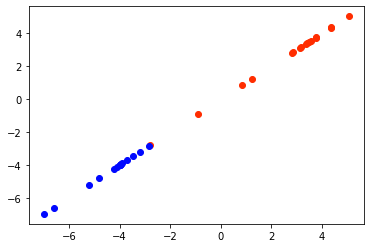

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(admin[:,0], admin[:,0], c='#FF2D00')
plt.scatter(inst[:,0], inst[:,0], c='#0008FF')
plt.show()

##기존 방법

In [ ]:
%tensorboard --logdir logs/fit

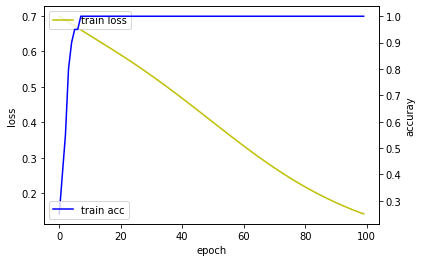

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
# acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

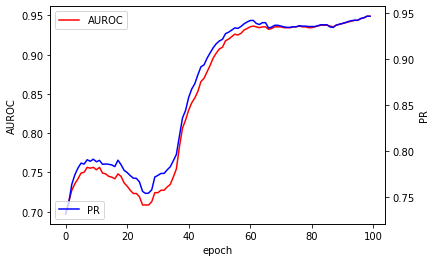

In [ ]:
fig, auc_ax = plt.subplots()

pr_ax = auc_ax.twinx()
roc_scores = validation_Callback.roc_scores
ap_scores = validation_Callback.ap_scores

auc_ax.plot(roc_scores, 'r', label='AUROC')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

pr_ax.plot(ap_scores, 'b', label='PR')
# acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

auc_ax.set_xlabel('epoch')
auc_ax.set_ylabel('AUROC')
pr_ax.set_ylabel('PR')

auc_ax.legend(loc='upper left')
pr_ax.legend(loc='lower left')

plt.show()

## Loss calculation for classification

In [ ]:
### Reference from https://github.com/tkipf/gcn/blob/master/gcn/metrics.py

def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)